In [312]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_classif, mutual_info_classif, chi2, SelectFromModel
from sklearn.naive_bayes import GaussianNB
from KL.kl.utils import load_fx
import numpy as np
window_size = 10
pair = 'EURUSD'
shift = 1
X, y_high, y_low, y_close, returns = load_fx(data_start=0, data_end=6000, shift=shift, window_size=window_size, pair=pair)
S = 50
X_trn_val = X[0:5500+S,:]
y_trn_val = y_close[0:5500+S]

Len = len(y_trn_val)
arr_idx = np.arange(Len)
np.random.shuffle(arr_idx)

arr_idx_train = arr_idx[:int(Len*0.8)]
arr_idx_val = arr_idx[int(Len*0.2):]

X_trn = X[arr_idx_train,:]
y_trn = y_close[arr_idx_train]

X_val = X[arr_idx_val,:]
y_val = y_close[arr_idx_val]

X_tst = X[5500+S:5520+S,:]
y_tst = y_close[5500+S:5520+S]
returns_tst = returns[5500+S:5520+S]

In [313]:
from sklearn.svm import SVC
import numpy as np
from itertools import combinations

# Get all combinations of 4 columns from 8 columns
comb_indices = list(combinations(range(8), 4))

base_model = RandomForestClassifier()
# base_model = LogisticRegression()
# base_model = GaussianNB()
# base_model = SVC()

# For each combination, create a 5000x4 matrix by selecting the corresponding columns
predictions_val, predictions_tst =[], []
for comb in comb_indices:
    X_trn_comb = X_trn[:, comb]
    X_val_comb = X_val[:, comb]
    X_tst_comb = X_tst[:, comb]
    
    base_model.fit(X_trn_comb, y_trn)
    
    predicted_y_val = base_model.predict(X_val_comb) 
    predicted_y_tst = base_model.predict(X_tst_comb)
    
    predictions_val.append(predicted_y_val)
    predictions_tst.append(predicted_y_tst)
    
predictions_val = np.array(predictions_val)
predictions_tst = np.array(predictions_tst)
# Now matrices_70 contains 70 matrices, each of size 5000x4
# Example of accessing the first matrix
# print(matrices_70[0].shape)  # Should output (5000, 4)

In [314]:
from diversity_metrics import disagreement_rate
disagreement_rate = disagreement_rate(predictions_val.T)

In [315]:
# # Majority Voting: Aggregate the predictions
# majority_vote = np.mean(predictions.T, axis=1) > 0.5
# accuracy = np.mean(majority_vote == y_tst)
# 
# print(f"Majority voting accuracy: {accuracy:.4f}")

In [316]:


# meta_model = RandomForestClassifier()
meta_model = GaussianNB()
meta_model.fit(predictions_val.T, y_val)
model_test_vote = meta_model.predict(predictions_tst.T)
accuracy = np.mean(model_test_vote == y_tst)
# 
print(f"Model voting accuracy: {accuracy:.4f}")

Model voting accuracy: 0.3500


In [317]:
profit = []
for idx in range(len(y_tst)):
    if model_test_vote[idx] == 1:
        profit.append(returns_tst[idx])
    else:
        profit.append(-returns_tst[idx])
profit = np.array(profit)

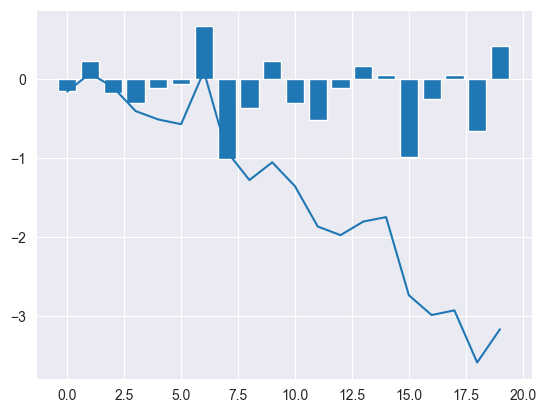

In [318]:
import matplotlib.pyplot as plt
plt.plot(np.cumsum( profit))
plt.bar(np.arange(len(profit)), profit)
plt.savefig(f'./figures/profit{S}.png')
plt.show()

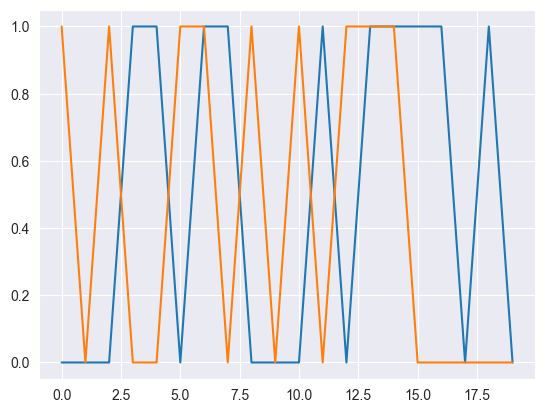

In [319]:

fig, ax = plt.subplots()
ax.plot(model_test_vote)
ax.plot(y_tst)
plt.show()

C(n, k) = \frac{n!}{k!(n-k)!}
